<a href="https://colab.research.google.com/github/spamz23/Applied-Deep-Learning/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático 1 - Aplicação de redes neuronais a um novo dataset
Dataset utilizado: [Titanic](https://public.opendatasoft.com/explore/dataset/titanic-passengers)

Trabalho realizado por:
* [Diogo Silva](https://github.com/spamz23)
* [Bruno Silva](https://github.com/brunosilva5)

# Instalar dependências

In [20]:
!pip install -r requirements.txt
# Limpar output
from IPython.display import clear_output
clear_output()

## 1. Fazer load dos dados
Para fazer load e tratar os dados, será utilizada a biblioteca pandas.

In [21]:
import pandas as pd

index = "PassengerId"
dataset = pd.read_excel("titanic-passengers.xlsx", index_col="PassengerId")


### Primeiro é importante analisar e perceber a estrutura dos dados

In [22]:
dataset

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
431,Yes,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28.0,0,0,110564,26.5500,C52,S
664,No,3,"Coleff, Mr. Peju",male,36.0,0,0,349210,7.4958,NaN,S
44,Yes,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,NaN,C
347,Yes,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S
891,No,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
779,No,3,"Kilgannon, Mr. Thomas J",male,NaN,0,0,36865,7.7375,NaN,Q
435,No,1,"Silvey, Mr. William Baird",male,50.0,1,0,13507,55.9000,E44,S
342,Yes,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S


### Informações obtidas
Na tabela acima podemos observar que o dataset de treino é composto por 891 linhas (cada linha corresponde a uma pessoa), e por 11 colunas.
Podemos então tirar as seguintes conclusões:
1. Existem várias colunas com variáveis categóricas (`Name`, `Sex`, `Ticket`, `Cabin`, `Embarked`). Todas estas terão que ser convertidas para números para se poderem usar na rede neuronal.
2. Existem algumas colunas com valores `NaN`, ou seja valores em falta. Todas estas também terão que se preencher, ou então remover do dataset.
3. A coluna `Survived`, tem apenas valores binários (`0` e `1`). Esta indica se a pessoa em questão sobreviveu (`1`) ou não (`0`). O objetivo da rede neuronal será prever os valores desta coluna. Esta coluna terá que ser separada das restantes, para que seja utilizada como output.


# 2. Tratamento dos dados
Tal como referido anteriormente existem "problemas" nos dados, que terão de ser resolvidos antes de os aplicar numa rede neuronal.

## 2.1 Valores em falta

Para saber quais as colunas que contêm valores `NaN` podemos utilizar o seguinte código:

In [23]:
print(f"Colunas com valores 'NaN': {dataset.columns[dataset.isna().any()].tolist()}")

Colunas com valores 'NaN': ['Age', 'Cabin', 'Embarked']


Podemos observar que existem 3 colunas com valores `NaN`: `Age`, `Cabin` e `Embarked`

### 2.1.1 Coluna 'Cabin'

In [24]:
missing = dataset["Cabin"].isnull().sum(axis=0)
total = dataset.shape[0]

print(f"Percentagem de valores em falta na coluna 'Cabin': {(missing*100)/total:.2f} %")

Percentagem de valores em falta na coluna 'Cabin': 77.10 %


Como 77.10 % dos dados, na coluna `Cabin`, estão em falta, iremos proceder à remoção desta coluna, pois a sua inclusão provavelmente não se iria traduzir num ganho de informação na rede neuronal.

In [25]:
dataset.drop(columns=['Cabin'], inplace=True)

### 2.1.2 Coluna 'Embarked'

In [26]:
missing = dataset["Embarked"].isnull().sum(axis=0)
total = dataset.shape[0]

print(f"Percentagem de valores em falta na coluna 'Embarked': {(missing*100)/total:.2f} %")

Percentagem de valores em falta na coluna 'Embarked': 0.22 %


Como nesta coluna apenas estão em falta apenas 0.22 % dos dados (o que corresponde a 2 linhas) e trata-se de uma variável categórica, iremos preencher os valores em falta com o valor mais frequente nesta coluna. Para isto iremos utilizar o módulo [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) disponibilizado pela biblioteca [scikit-learn](https://scikit-learn.org/).

In [27]:
from sklearn.impute import SimpleImputer
import numpy as np
# Criar objeto imputer com estratégia 'most_frequent'
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose=0)
# Aplicar na coluna 'Embarked'. Como vamos aplicar apenas a uma coluna, e o método espera um array 2D, é necessário fazer um reshape dos dados
dataset["Embarked"] = imp_most_frequent.fit_transform(dataset["Embarked"].values.reshape(-1, 1))

### 2.1.3 Coluna 'Age'

In [28]:
missing = dataset["Age"].isnull().sum(axis=0)
total = dataset.shape[0]

print(f"Percentagem de valores em falta na coluna 'Age': {(missing*100)/total:.2f} %")

Percentagem de valores em falta na coluna 'Age': 19.87 %


Nesta coluna estão em falta 19.87 % e trata-se de uma variável numérica, iremos preencher os valores em falta com o valor médio da coluna `Age`. Para isto iremos utilizar o mesmo módulo utilizado na coluna anterior. Existem 2 metodologias possíveis para o preenchimento de variáveis numéricas:
1. Utilizar a média dos valores da coluna;
2. Utilizar a mediana dos valores da coluna.
Para decidir qual a melhor estratégia é necessário observar a curva de distribuição dos dados desta coluna (`Age`).

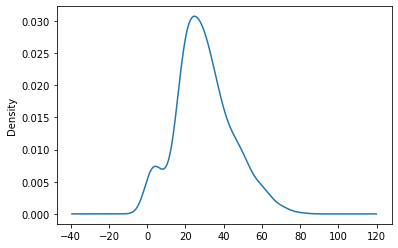

In [29]:
dataset["Age"].plot.kde()

Como é possível observar na figura acima, os dados não seguem uma distribuição normal. Assim concluímos que será mais vantajoso utilizar a mediana para o preenchimento dos valores em falta.

In [30]:
from sklearn.impute import SimpleImputer
import numpy as np
# Criar objeto imputer com estratégia 'median'
imp_median = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
# Aplicar na coluna 'Age'. Como vamos aplicar apenas a uma coluna, e o método espera um array 2D, é necessário fazer um reshape dos dados
dataset["Age"] = imp_median.fit_transform(dataset["Age"].values.reshape(-1, 1))

## 2.2 Transformar valores categóricos em valores numéricos

Para saber quais as colunas que contêm valores não numéricos podemos utilizar o seguinte código:

In [31]:
non_numeric_columns = dataset.columns.difference(dataset._get_numeric_data().columns).to_list()
print(f"Colunas não númericas: {non_numeric_columns}")

Colunas não númericas: ['Embarked', 'Name', 'Sex', 'Survived', 'Ticket']


### 2.2.1 Coluna 'Embarked', 'Sex', 'Name', 'Ticket'
Em primeiro lugar iremos remover as colunas `Name` e `Ticket`, pois estas são únicas dos passageiros.
Para transformar os valores das restantes colunas (`Embarked`, `Sex`) em valores numéricos iremos utilizar o método `get_dummies()` da biblioteca `pandas`. Este método irá criar, para cada coluna, novas `n` colunas, onde `n` é o numero de diferentes classes presentes em cada coluna. Estas novas colunas irão conter valores binários que indicam se uma linha pertence ou não a essa classe. 

Uma outra alternativa mais simples seria transformar, para cada coluna, cada classe diferente num valor inteiro diferente. Apesar de ser mais simples, esta tranformação poderia introduzir uma falsa sensação de hierarquiedade nos dados, o que poderia levar a rede neuronal a aprender falsas suposições. 

In [32]:
dataset.drop(columns=["Name", "Ticket"], inplace=True)
# Fazer OneHotEncoding para todas as colunas não numéricas, excepto a coluna 'Survived'
dataset = pd.get_dummies(dataset, columns=["Embarked", "Sex"])

### 2.2.2 Coluna 'Survived'
As transformações a esta coluna são simples. Esta apenas contêm os valores `Yes` ou `No`. Apenas temos que transformar estes valores para `1` ou `0`, respetivamente.

In [33]:
dataset["Survived"] = dataset['Survived'].map({'Yes': 1, 'No': 0})

## 2.3 Criar novos 'features' a partir de existentes
No dataset existe a coluna `SibSp` que indica o número de irmãos/cônjuges, do passageiro, a bordo. Existe também a coluna `Parch` que indica o número de pais/filhos, do passageiro, a bordo.
Como estas 2 colunas estão intrinsecamente relacionadas, decidimos uni-las numa só coluna, a que chamamos de `Family_Members`, que indica o número total de familiares a bordo do navio.

In [34]:
# União das colunas
dataset["Family_Members"] = dataset["SibSp"] + dataset["Parch"]
# Apagar colunas que já não são necessárias
dataset.drop(columns=["SibSp", "Parch"], inplace=True)

## 2.4 Separação da coluna 'Survived'
É também importante separar a coluna `Survived` do resto do dataset. Iremos criar 2 variáveis,  `X`  (irá conter os dados), e `y` (irá conter a coluna `Survived`)

In [35]:
X = dataset[dataset.columns.difference(["Survived"])]
y = dataset[["Survived"]]

## 2.5 Normalização de dados

In [36]:
from sklearn.preprocessing import StandardScaler

# Definir colunas a normalizar
cols = ["Pclass", "Age", "Family_Members", "Fare"]
# Normalizar os dados
scaled_columns = StandardScaler().fit_transform(X[cols].values)
# Juntar os dados normalizados com os outros
X = np.concatenate([X[X.columns.difference(cols)], scaled_columns], axis=1)


## 2.6 Divisão dos dados

In [37]:
from sklearn.model_selection import train_test_split
# Dividir dados em treino e teste. 
# 20% dos dados são usados para teste
# random_state = 42, para resultados reproduzíveis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# 3. Construir e treinar a Rede Neuronal

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics

es_cb = EarlyStopping(monitor = "val_auc", patience = 10, mode = "max")

class KerasModel:
    def __init__(self, n_features):
      self.n_features = n_features
  
    def build_model(self):
      # Criar modelo sequencial
      model = Sequential()
      # Criar camadas 'Dense'
      model.add(Dense(12, input_dim = self.n_features, activation = 'relu'))
      model.add(Dense(8, activation = 'relu'))
      # Ativação = 'sigmoid' para os valores de saída serem 0 ou 1
      model.add(Dense(1, activation = 'sigmoid'))
      # Compilar modelo
      # Optimizar métrica 'AUC' para melhores resultados em classificação binária 
      model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metrics.AUC()])
      return model

model = KerasClassifier(KerasModel(X_train.shape[1]).build_model, callbacks = [es_cb], epochs = 1000, validation_split = 0.2)
# Treinar modelo
model.fit(X_train, y_train)

Epoch 1/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.7479 - auc_1: 0.4030 - val_loss: 0.7367 - val_auc_1: 0.4196
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.7033 - auc_1: 0.4643 - val_loss: 0.6955 - val_auc_1: 0.4904
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.6707 - auc_1: 0.5382 - val_loss: 0.6640 - val_auc_1: 0.5796
Epoch 4/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.6447 - auc_1: 0.6244 - val_loss: 0.6359 - val_auc_1: 0.6629
Epoch 5/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.6216 - auc_1: 0.7037 - val_loss: 0.6101 - val_auc_1: 0.7277
Epoch 6/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.5988 - auc_1: 0.7509 - val_loss: 0.5856 - val_auc_1: 0.7686
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.5770 - auc_1: 0.7829 - val_loss: 0.5613 - val_auc_1: 0.7919
Epoch 8/1000
18/18 [===========================